# Examination Timetabling using Genetic Algorithm

### Name : SHAURYA BHAGAT 
### GUID  : 2654146B

#### Necessary imports

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm, trange
from atpbar import atpbar
import copy
import timeout_decorator
import gc

#### Loading dataset and setting available timeslots 

In [2]:
# student and enrollment data from benchmark dataset from Uni of Nottingham
students = pd.read_csv('Nott/students', names=['student_code','course_code'], delimiter=' ')
enrollements = pd.read_csv('Nott/enrolements', names=['student_code','exam_code'], delimiter=' ')

# Examination halls and their capacities data from Uni of Glasgow
rooms_df = pd.read_csv('UofG_data/Rooms.csv', names=['room_name','room_id','capacity'])

# enrollments dataframe sorted as per exam codes and replaced
enrollements.sort_values(by='exam_code', inplace=True)
capacity = rooms_df['capacity'].to_list()

# Dictionary to map exam code to the students enrolled in that exam
students_in_exam = {}

for index, row in enrollements.iterrows():
    student_list = students_in_exam.get(row['exam_code'], [])
    student_list.append(row['student_code'])
    students_in_exam[row['exam_code']]=student_list

# Dictionary to map exam index to the respective exam code
index_to_exam = {}
count=0
for i in enrollements['exam_code'].unique().tolist():
    index_to_exam[count] = i
    count+=1
    
# Number of rooms, timeslots and total courses are defined that remain constant throughout
N_Rooms = len(rooms_df)
N_TimeSlots = 33        #11 days * 3 slots a day
N_courses = len(students_in_exam)

#### Exploratory Data Analysis

In [3]:
print('Total Number of courses = ', N_courses)
print('Total Number of students = ', len(students))
print('Total Number of enrollments = ', len(enrollements))
print('Total Number of examination halls = ', N_Rooms, '\n')
print('Total Number of timeslots \n = number of days * number of slots each day * number of halls available \n  = 11 * 3 * 37 \n   =',
     11 * 3 * 37, 'timeslots')


Total Number of courses =  800
Total Number of students =  7896
Total Number of enrollments =  33997
Total Number of examination halls =  37 

Total Number of timeslots 
 = number of days * number of slots each day * number of halls available 
  = 11 * 3 * 37 
   = 1221 timeslots


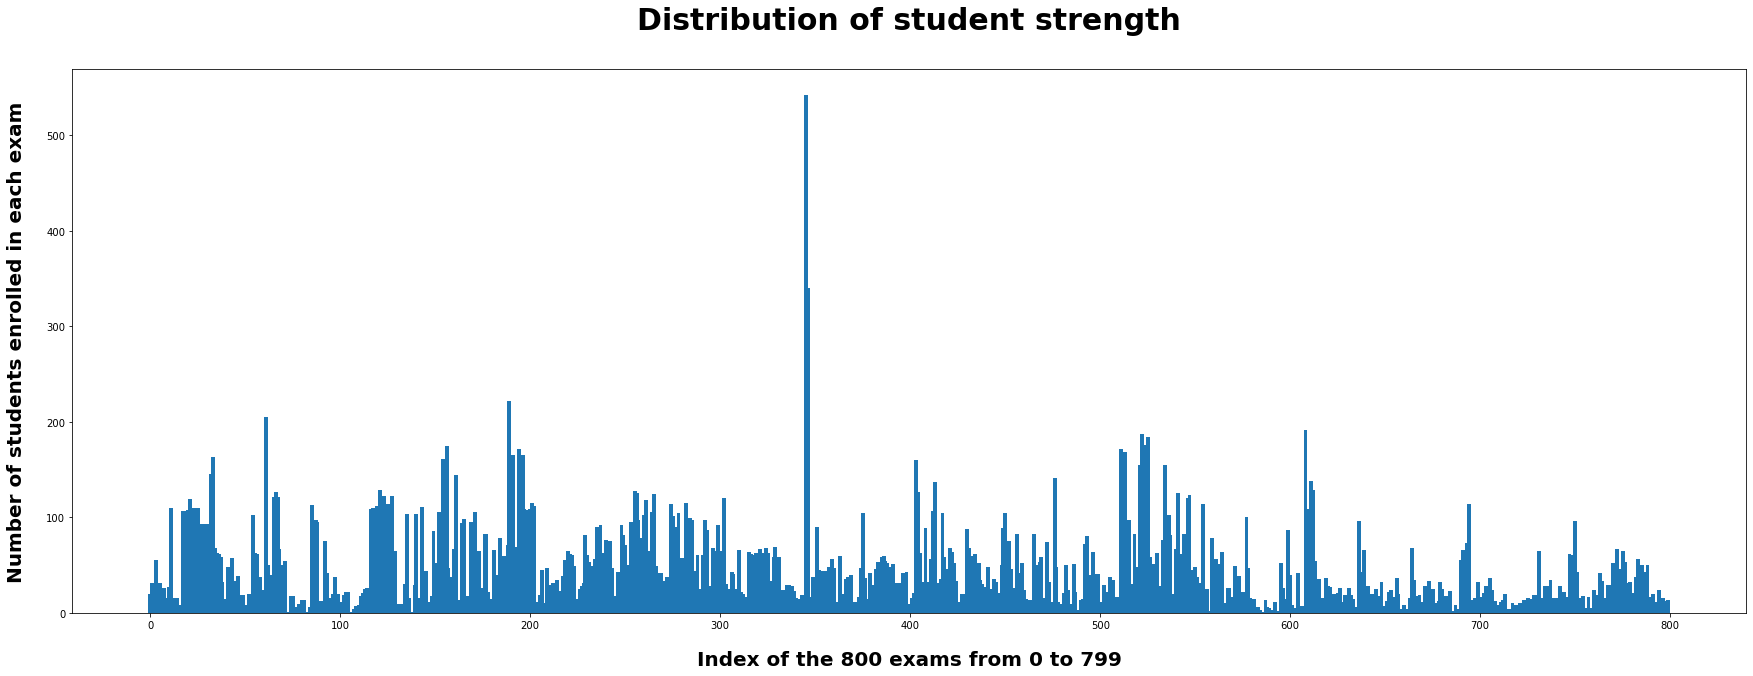

In [4]:
# to analyze the distribution of the student strengths over the different courses
student_strength = [len(student_list) for exam, student_list in students_in_exam.items()]
plt.figure(figsize = (30,10))
plt.bar(index_to_exam.keys(),student_strength, width=2)
plt.xlabel('Index of the 800 exams from 0 to 799', fontweight='bold', fontsize=20.0, labelpad = 20)
plt.ylabel('Number of students enrolled in each exam', fontweight='bold', fontsize=20.0, labelpad = 20)
plt.title('Distribution of student strength', fontweight='bold', fontsize=30.0, pad = 40)
plt.show()

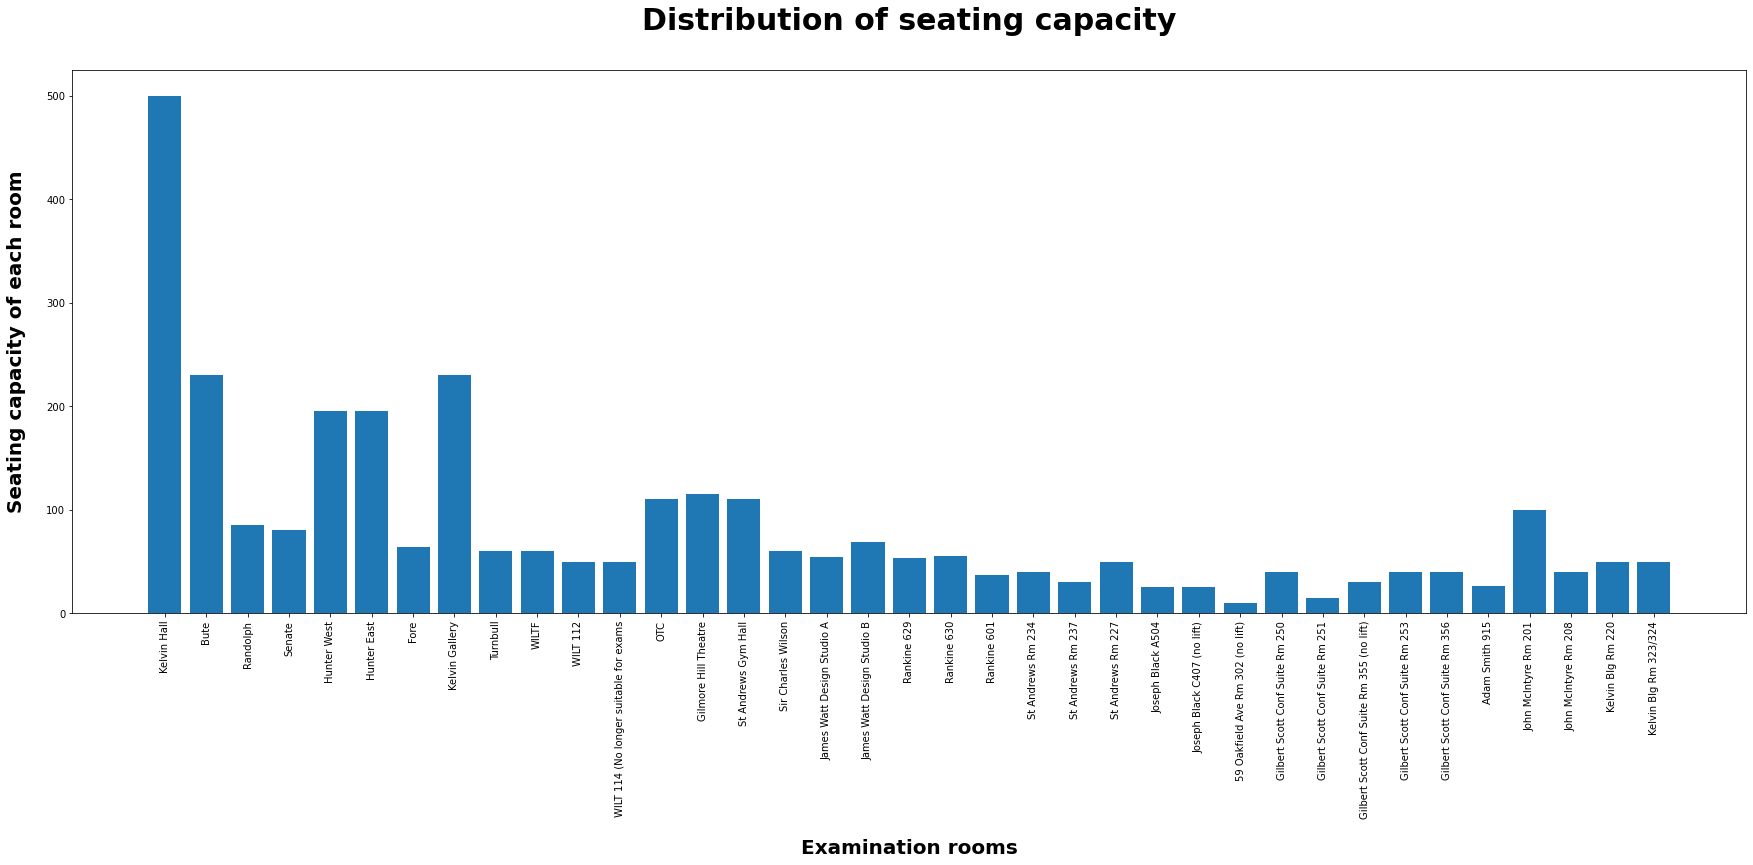

In [5]:
# to analyze the distribution of the seating capacities over the different examination halls
plt.figure(figsize = (30,10))
plt.bar(rooms_df['room_name'], rooms_df['capacity'], )
plt.xticks(rotation = 90)
plt.xlabel('Examination rooms', fontweight='bold', fontsize=20.0, labelpad = 20)
plt.ylabel('Seating capacity of each room', fontweight='bold', fontsize=20.0, labelpad = 20)
plt.title('Distribution of seating capacity', fontweight='bold', fontsize=30.0, pad = 40)
plt.show()


  

### Defining necessary functions


  

#### Defining a function for initial spawn of generation 0 and for creating immigrants

In [6]:
# Normal non-greedy method, may contain multiple capacity constraint violations
def create_schedule():
    
    # column 1 for courses
    col1 = np.arange(0,N_courses).reshape(N_courses,1)
    
    # column 2 for the allocated timeslots that are randomly chosen
    col2 = np.random.choice((N_Rooms * N_TimeSlots), size=800, replace=False).reshape(N_courses,1)
    arr = np.concatenate([col1, col2], axis=1)
    sch = arr[arr[:,1].argsort()]
    
    return sch

In [7]:
# Greedy method, does not contain any capacity constraint violations

@timeout_decorator.timeout(2)

def create_greedy_schedule():
    
    # column 1 for courses
    col1 = np.arange(0,N_courses).reshape(N_courses,1)
    col2_list = []

    # maintaining a list of total available timeslots = 1221
    total_timeslots = np.arange((N_Rooms * N_TimeSlots)).tolist()
    
    for exam in col1:
        
        # student strength is calculated
        strength = len(students_in_exam.get(index_to_exam.get(exam[0])))
        
        # avaialable list of timeslots is filtered down based rooms that meet the capacity constraint
        choice_list = [timeslot for timeslot in total_timeslots if (strength<=capacity[timeslot%37]) == True]
        
        choice = random.choice(choice_list)
        
        # column 2 for the allocated timeslots that are randomly chosen from filtered list
        col2_list.append(choice)
        
        # once a timeslot is allocated it is removed from the available list of timeslots
        total_timeslots.remove(choice)
        
    col2 = np.array([col2_list]).T
    
    
    arr = np.concatenate([col1, col2], axis=1)
    sch = arr[arr[:,1].argsort()]
    
    return sch


#### Defining a function for schedule repair after n-point crossover

In [8]:
def repair_schedule(schedule):
    
    exam_list = []
    used_timeslots = []
    
    # total exams list
    total_exams = np.arange(800).tolist()
    
    # total timeslots list
    total_timeslots = np.arange((N_Rooms * N_TimeSlots)).tolist()
    
    # mark the duplicate entries as -99 for deletion later and
    # form a list of unique exams present in the child after crossover 
    for i in range(len(schedule)):
        
        if schedule[i][0] in exam_list:
            schedule[i][1] = -99
        else:
            exam_list.append(schedule[i][0])
    
    # delete marked duplicates
    schedule = np.delete(schedule, np.where(schedule == -99)[0], axis=0)        
    
    # form a list of unique timeslots already used in the child after crossover 
    used_timeslots = schedule[:,1].tolist()
    
    # filter down the total exams list to contain only the ones that are not scheduled at all after crossover
    remaining_exams = [exam for exam in total_exams if exam not in exam_list]
    
    # filter down the total timeslots list to contain the remaining available ones
    remaining_timeslots = [timeslot for timeslot in total_timeslots if timeslot not in used_timeslots]

    col2 = []
    
    # allocate timeslots to remainig exams in a greedy way as if creating a new individual during initial spawn
    for exam in remaining_exams:
        
        strength = len(students_in_exam.get(index_to_exam.get(exam)))
        
        choice_list = [timeslot for timeslot in remaining_timeslots if (strength<=capacity[timeslot%37]) == True]
        
        choice = random.choice(choice_list)
        
        col2.append(choice)
        
        remaining_timeslots.remove(choice)

    temp = np.array([remaining_exams,col2]).T

    schedule = np.concatenate([schedule,temp],axis=0)
    
    sch = schedule[schedule[:,1].argsort()]
    
    return sch

#### Defining functions that calculate individual constraint conflicts

In [9]:
# To return the number of allocations where the capacity conflict is violated
def capacity_conflict(schedule):
    
    rating = 0
    
    # interated through all rows of the array
    for sch in schedule:
        
        # sch[0] is for first column value (exam index)
        strength = len(students_in_exam.get(index_to_exam.get(sch[0])))
        
        # sch[1] is for second column (timeslot index)
        # As capacity is a just a list of size 37 and not a 2D array, mod 37 is used to convert timeslot 
        # index to the respective room's capacity
        if (strength<=capacity[sch[1]%37]) == False:
            
            # weight of this constraint is 100
            rating+=100
    return rating

In [10]:
# To return the number of students who have more than 2 exams scheduled in a single day
def max_2_exams_in_1_day(schedule):
    rating = 0
    
    # the logic is to form a cumulative list of all students in all exams in a single day
    
    # the outer loop runs for 11 times, i.e., for every day, covering all 37 rooms for  
    # morning, afternoon and evening slots = 37 * 3 = 111 slots a day
    # therefore values of i -> start = 111 | stop = 1221 | step = 111
    for i in range(N_Rooms*3, (N_Rooms*N_TimeSlots)+1, N_Rooms*3):
        
        student_list = []
        
        # the inner loop runs for the number of exams having allocated timeslots between i-111 to i
        # for example for the first iteration, x will have all exams having timeslots between 0 to 111
        for x in schedule[np.where((schedule[:,1] >= i-(N_Rooms*3)) & (schedule[:,1] < i))]:
            
            # x[0] is the exam index, index_to_exam maps the exam index to the exam code
            # and students_in_exam maps the exam code to the list of students
            for s in students_in_exam.get(index_to_exam.get(x[0])):
                
                student_list.append(s)
        
        # res contains count of the occurence of every student in the list formed by inner loop 
        res = Counter(student_list)
        # fit contains students who have occured more than 2 times in the above list
        # this signifies constraint violation
        fit = [[k, v] for k, v in res.items() if v > 2]
        # weight of this constraint is 1
        rating +=  len(fit)

    return rating    
    

In [11]:
# To return the number of students who have more than 1 exams scheduled in a single time slot
def same_slot_conflict(schedule):
    
    rating = 0
    
    # the logic is to form a cumulative list of all students in all exams in a single slot
    
    # the outer loop runs for 33 times, i.e., for every slot, covering all 37 rooms 
    # Therefore values of i -> start = 37 | stop = 1221 | step = 37
    for i in range(N_Rooms, (N_Rooms*N_TimeSlots)+1, N_Rooms):
        
        student_list = []
        
        # the inner loop runs for the number of exams having allocated timeslots between i-37 to i
        # for example for the first iteration, x will have all exams having timeslots between 0 to 37
        for x in schedule[np.where((schedule[:,1] >= i-N_Rooms) & (schedule[:,1] < i))]:
            
            # x[0] is the exam index, index_to_exam maps the exam index to the exam code
            # and students_in_exam maps the exam code to the list of students
            for s in students_in_exam.get(index_to_exam.get(x[0])):
                
                student_list.append(s)

        # res contains count of the occurence of every student in the list formed by inner loop         
        res = Counter(student_list)
        # fit contains students who have occured more than once in the above list
        # this signifies constraint violation
        fit = [[k, v] for k, v in res.items() if v > 1]
        # weight of this constraint is 1
        rating +=  len(fit)

    return rating    

#### Defining a function that gives separate penalty scores and a cumulative 

In [12]:
def fitness_rating(schedule):
    
    tot_rating = []
    
    tot_rating.append(capacity_conflict(schedule))
    
    tot_rating.append(same_slot_conflict(schedule))
    
    tot_rating.append(max_2_exams_in_1_day(schedule))
    
    tot_rating.append(sum(tot_rating))
    
    return tot_rating

#### Defining a function that spawns generation 0 of generation size N

In [13]:
def create_gen0(N):
    
    population = []
    
    # atpbar presents a nice progress bar to track the elapsed and estimate completion time
    for i in atpbar(range(N), name='Genration 0', time_track=True):
        try:
            # greedy method
            schedule = create_greedy_schedule()
            # if non-greedy approach is to be used please uncomment the below and comment the above line
#             schedule = create_schedule()
            
            # a list of all the individuals along with their penalty score is returned
            population.append([schedule, fitness_rating(schedule)])
            
        except:
            i -=1
        
    return population

#### Parent selection methods are defined

In [14]:
# inputs are the generation and tournament size
def tournament_selection(generation, size):
    
    # randomly selecting contestants based on the tournament size
    contestants_ind = np.random.choice(range(len(generation)), size = size, replace = False)
    contestants = []
    
    for i in contestants_ind:
        contestants.append(generation[i])
    
    # contestants are competed
    contestants.sort(key = lambda x: x[1][-1])
    
    # the winner is returned
    return contestants[0]

In [15]:
# only the generation is required as input
def roulette_wheel_selection(generation):
    
    # selection probabilities are calculated which is based on the penalty values (fitness rating)
    generation.sort(key = lambda x: x[1][-1])
    max = sum([c[1][-1] for c in generation])
    selection_probs = [c[1][-1]/max for c in generation]
    
    # as penalty score is inversely proportional to the fitness the list had to be reversed
    selection_probs = selection_probs[::-1]

    selected_ind = np.random.choice(range(len(generation)), p = selection_probs)

    return generation[selected_ind]

In [16]:
# selection of parent which is completely random
def random_selection(generation):
    
    selected_ind = np.random.randint(0, len(generation))
    
    return generation[selected_ind]

#### Crossover methods are defined

In [17]:
# one-point crossover takes in 2 parents and outputs 2 children
# Child 1 is created by concatenating exams from index 0 to the crossover point
# of parent a and from the crossover point + 1 to the end of parent b. Child 2 is 
# created by vice versa of child 1

def one_point_crossover(parent_a, parent_b):
    
    crossover_point = np.random.randint(1, parent_a.shape[0]-1)
    
    child_1 = np.concatenate([parent_a[:][:crossover_point],
                         parent_b[:][crossover_point:]
                        ])
    # post crossover the child is repaired
    child_1 = repair_schedule(child_1)
    
    child_2 = np.concatenate([parent_b[:][:crossover_point], 
                         parent_a[:][crossover_point:]
                        ])
    # post crossover the child is repaired
    child_2 = repair_schedule(child_2)
        
    return child_1, child_2

In [18]:
# two-point crossover takes in 2 parents and outputs 2 children
# Child 1 is created by concatenating exams from index 0 to the first crossover point
# of parent a, from the first crossover point + 1 to the second crossover point of 
# parent b and from the second crossover point + 1 to the end of parent a. Child 2 is created
# by vice versa of child 1

def two_point_crossover(parent_a, parent_b):
    
    crossover_points = sorted(np.random.randint(1, parent_a.shape[0]-1, size = 2))
    
    child_1 = np.concatenate([parent_a[:][:crossover_points[0]],
                         parent_b[:][crossover_points[0]:crossover_points[1]], 
                         parent_a[:][crossover_points[1]:]
                        ])
    # post crossover the child is repaired
    child_1 = repair_schedule(child_1)
    
    child_2 = np.concatenate([parent_b[:][:crossover_points[0]],
                         parent_a[:][crossover_points[0]:crossover_points[1]], 
                         parent_b[:][crossover_points[1]:]
                        ])
    # post crossover the child is repaired
    child_2 = repair_schedule(child_2)
    
    return child_1, child_2

#### Mutation function is defined

In [19]:
# 8 random examinations out of the total 800 are selected. For those examinations,new timeslots
# are randomly assigned in a similar way as if creating a new individual during initial spawn

@timeout_decorator.timeout(2)

def mutate(schedule):
    mutation_points = sorted(np.random.randint(0, schedule.shape[0], size = 8))
    
    total_timeslots = np.arange((N_Rooms * N_TimeSlots)).tolist()
    used_timeslots = schedule[:,1].tolist() 
    remaining_timeslots = [timeslot for timeslot in total_timeslots if timeslot not in used_timeslots]
    
    for i in mutation_points:
        
        strength = len(students_in_exam.get(index_to_exam.get(schedule[i,0])))
    
        choice_list = [timeslot for timeslot in remaining_timeslots if (strength<=capacity[timeslot%37]) == True]
        choice = random.choice(choice_list)
        
        remaining_timeslots.append(schedule[i,1])
        schedule[i,1] = choice
        
    return schedule

In [20]:
# a simple function to check whether the child schedule is already a part of the current generation 
def already_exist(schedule, generation):
    l = [p[0] for p in generation]
    flag = False
    for i in l:
        if(np.array_equal(schedule, i)) == True:
            flag = True
            
    if flag == False:
        return False
    else:
        return True

In [21]:
# a file to store the progress at every generation with the best and average.
f = open('results/progress.csv', 'w')
f.write("%s,%s,%s\n"%('Gen no','Gen best', 'Gen Avg'))
f.close()

### The main evolution function to implement the genetic algorithm

This function takes in the following parameters :
 1. Generation size N
 2. Tournament size for tournament selection method
 3. Immigration size
 4. Max number of generations 
 5. Mutation probability
 6. Elite size
 
The logic of this function is -

    To spawn generation 0
    
    Loop till max number of generations are elapsed
    
    Curr generation is the parent generation
    
    In Every loop, N/2 parents are selected and N children are created through crossover
    
    Some of them are mutated with a set probability of mutation
    
    Next generation is the child generation
    
    In every iteration the next child generation replaces the parent generation to become the new current generation  

In [22]:
def evolution(Gen_size, tournament_size, immigration_size, No_of_gen, mutation_prob, elite_size):
    
    # first step is to create generation 0
    curr_gen = create_gen0(Gen_size)
    next_gen = []
    next_gen_avg = []
    best_candidates = []
    
    # the variable 'variability_size' keeps track of the extent of new genetic diversity to be introduced
    # in every generation
    variability_size = immigration_size
    count = 0
    
    # outer loop to run till max number of generations have elapsed
    for i in atpbar(range(No_of_gen), name='Next Generations', time_track=True):
        
        # this if helps to skip the elitism for generation 0
        if (i > 0):
            
            # Elitism is applied to replace parent generation with elites + child generation to form 
            # the new current generation
            curr_gen = curr_gen[:elite_size] + next_gen[:Gen_size - elite_size]
            next_gen = []

        # all individuals are ranked based on their fitness
        curr_gen.sort(key = lambda x: x[1][-1])
        
        # the best individual of the generation is stored
        best_candidates.append(curr_gen[0][1])

        # to break out of the loop if ideal condition is met
        if(best_candidates[i][-1] == 0):
            break
            
        
        curr_gen = curr_gen[:Gen_size - immigration_size]
        
        # to keep track of the generation's average fitness 
        next_gen_avg.append(sum([c[1][-1] for c in curr_gen]) / len(curr_gen))        
        
        # to increase the variability size if there is a local minima (average fitness does not change
        # over 2 or more generations consecutively)
        if((i > 0) and (next_gen_avg[i-1]==next_gen_avg[i])):
            
            count += 1
            
            # if average fitness is same for more than 1 generations, double the variability size 
            if count > 0 and count < 10:
                variability_size = 2 * immigration_size
            # if average fitness is same for more than 10 generations, triple the variability size
            elif count < 20:
                variability_size = 3 * immigration_size
            else:
            # if average fitness is same for more than 20 generations, quadruple the variability size
                variability_size = 4 * immigration_size
            
        else:
            # if average fitness updates, then variability size is same as the immigration size
            variability_size = immigration_size
            count = 0
        
        # progress file is appended with the current generation's results
        f = open('results/results17.csv', 'a')
        f.write("%s,%s,%s,%s\n"%(i, curr_gen[0][1][-1], next_gen_avg[i], variability_size))
        f.close()
        
        print('gen', i, ' best = ', curr_gen[0][1], 'and gen avg = ', next_gen_avg[i],
             'variability is ', variability_size)

        # Immigration
        for m in range(variability_size):

            try:
                child = create_greedy_schedule()
                child_fitness = fitness_rating(child)
                next_gen.append([child, child_fitness])
            except:
                m -= 1
        
        #Parent selection
        for j in range(Gen_size/2):
            
            # 50-50 chance of parent_a selection via tournament or roulette wheel
            if random.random() < 0.5:
                parent_a = tournament_selection(curr_gen, tournament_size)

            else :
                parent_a = roulette_wheel_selection(curr_gen)
            
            # complete random selection for parent_b
            parent_b = random_selection(curr_gen)
            
            # the following determines how many children are to be created from the selected
            # pair of parents in j loop
            for k in range(1):
                
                # try loop to track any timeouts
                try:
                    
                    # 50-50 chance of crossover by one-point or two-point crossover
                    crossover_choice = random.choice(['one-point','two-point'])

                    if crossover_choice == 'one-point':    
                        child_1, child_2 = one_point_crossover(parent_a[0], parent_b[0])
                        
                    elif crossover_choice == 'two-point':
                        child_1, child_2 = two_point_crossover(parent_a[0], parent_b[0])
                    
                    # penalty score of the children are calculated
                    child_1_fitness = fitness_rating(child_1)
                    child_2_fitness = fitness_rating(child_2)
                    
                    # only if the children are not present in the parent generation they are added to the
                    # next generation
                    if already_exist(child_1, next_gen) == False:
                        next_gen.append([child_1, child_1_fitness])
                        
                    if already_exist(child_2, next_gen) == False:
                        next_gen.append([child_2, child_2_fitness])
                    
                    # mutation is applied based on the set mutation probabilty
                    if random.random() < mutation_prob:
                        mutated_child = mutate(random.choice([child_1, child_2]))
                        mutated_child_fitness = fitness_rating(mutated_child)

                        next_gen.append([mutated_child, mutated_child_fitness])
                    
                except:    
                    k -= 1
        
        # child generation created is also ranked based on their fitness
        next_gen.sort(key = lambda x: x[1][-1])
        
        # explicit garbage collection just as an extra precaution
        gc.collect()

    # The best candiates from every generation and the individuals from the last generation are returned
    # There will be more than 1 individuals which represent a 'good enough' solution
    return best_candidates, next_gen

In [ ]:
# best results obtained with the below parameter values
best, next_gen = evolution(Gen_size = 100,
                           tournament_size = 10,
                           immigration_size = 5,
                           No_of_gen = 2000,
                           mutation_prob = 0.2,
                           elite_size = 10)

In [ ]:
# the individuals from the last generation that are returned are stored
f1 = open('results/last_gen.txt', 'w')
for c in next_gen:
    np.savetxt(f1, c[0], delimiter =",", fmt='%s')
    f1.write(str(c[1]))
    f1.write('\n\n')
f1.close

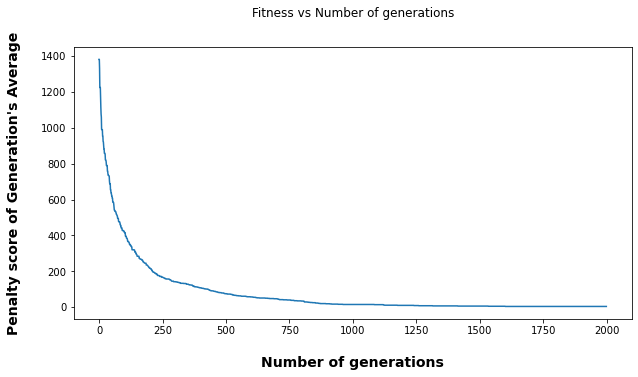

In [23]:
av = pd.read_csv('results/17/results17.csv')
plt.figure(figsize=(10,5))
plt.plot(range(len(av['Gen best'])), av['Gen best'])
plt.xlabel('Number of generations', fontweight='bold', fontsize=14.0, labelpad = 20)
plt.ylabel("Penalty score of Generation's Average", fontweight='bold', fontsize=14.0, labelpad = 20)
plt.title('Fitness vs Number of generations', pad=30)
plt.show()

#### Below is the definiton of the evolution function that implements the elitism approach where all the parents and children are grouped together and the top N (generation size) individuals become the next generation

In [24]:

# def evolution(Gen_size, tournament_size, immigration_size, No_of_gen, mutation_prob):
    
#     next_gen = create_gen0(Gen_size)    
#     next_gen_avg = []
#     best_candidates = []
    
#     variability_size = immigration_size
#     count = 0
        
#     for i in atpbar(range(No_of_gen), name='Next Generations', time_track=True):
        
#         next_gen.sort(key = lambda x: x[1][-1])
#         best_candidates.append(next_gen[0][1])

#         if(best_candidates[i][-1] == 0):
#             break
            
        
#         next_gen = next_gen[:Gen_size - immigration_size]

#         next_gen_avg.append(sum([c[1][-1] for c in next_gen]) / len(next_gen))        
        
#         if((i > 0) and (next_gen_avg[i-1]==next_gen_avg[i])):
            
#             count += 1
            
#             if count > 0 and count < 10:
#                 variability_size = 2 * immigration_size
#             elif count < 20:
#                 variability_size = 3 * immigration_size
#             else:
#                 variability_size = 4 * immigration_size
            
#         else:
#             variability_size = immigration_size
#             count = 0
        
#         f = open('results/results11.csv', 'a')
#         f.write("%s,%s,%s,%s\n"%(i, next_gen[0][1][-1], next_gen_avg[i], variability_size))
#         f.close()
        
#         print('gen', i, ' best = ', next_gen[0][1], 'and gen avg = ', next_gen_avg[i],
#              'variability is ', variability_size)

#         for m in range(variability_size):

#             try:
#                 child = create_greedy_schedule()
#                 child_fitness = fitness_rating(child)
#                 next_gen.append([child, child_fitness])
#             except:
#                 m -= 1

#         for j in range(10):

#             if random.random() < 0.5:
#                 parent_a = tournament_selection(next_gen, tournament_size)
# #                 parent_b = tournament_selection(next_gen, tournament_size)
#             else :
#                 parent_a = roulette_wheel_selection(next_gen)
# #                 parent_b = roulette_wheel_selection(next_gen)

#             parent_b = random_selection(next_gen)
    
#             for k in range(3):
#                 try:

#                     crossover_choice = random.choice(['one-point','two-point'])

#                     if crossover_choice == 'one-point':    
#                         child_1, child_2 = one_point_crossover(parent_a[0], parent_b[0])
                        
#                     elif crossover_choice == 'two-point':
#                         child_1, child_2 = two_point_crossover(parent_a[0], parent_b[0])
                        
#                     child_1_fitness = fitness_rating(child_1)
#                     child_2_fitness = fitness_rating(child_2)

#                     if already_exist(child_1, next_gen) == False:
#                         next_gen.append([child_1, child_1_fitness])
                        
#                     if already_exist(child_2, next_gen) == False:
#                         next_gen.append([child_2, child_2_fitness])
                        
#                     if random.random() < mutation_prob:
#                         mutated_child = mutate(random.choice([child_1, child_2]))
#                         mutated_child_fitness = fitness_rating(mutated_child)

#                         next_gen.append([mutated_child, mutated_child_fitness])
                    
#                 except:    
#                     k -= 1
        
#         gc.collect()

#     return best_candidates, next_gen
